# Up-down Rep counter

### The up-down rep counter mathematically calculates if the keypoints are shrinking or expanding. Expanding will be classified as up-rep and shrinking will be classified as down-rep.

## Imports

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt

## Reading in the keypoints

In [2]:
os.listdir()

workout_data = pd.read_csv("./db-sumo-squat.csv")

In [3]:
workout_data

,Unnamed: 0,keypoints
0,0,[[104.20311786 101.19473073]\n [113.47085704 ...
1,1,[[104.13966445 101.11467924]\n [113.44788367 ...
2,2,[[102.9557314 100.24298927]\n [112.6050403 ...
3,3,[[103.1048369 100.32123994]\n [112.76063092 ...
4,4,[[102.42566825 99.93424433]\n [111.41352805 ...
...,...,...
400,400,[[ 91.13900469 127.36972639]\n [ 98.48026474 1...
401,401,[[ 91.08336668 127.40048038]\n [ 98.44872063 1...
402,402,[[ 90.22618332 129.28494691]\n [ 98.24977536 1...
403,403,[[ 90.15513577 129.13665633]\n [ 98.2079149 1...


## Convert keypoints to numpy arrays

In [4]:
def convert_keypoints_to_np(keypoint_string):
    numbers = re.findall("\[\s*-*\d+.\d+\s+-*\d+.\d+\s*\]", keypoint_string)
    
    new_num_arr = []
    for num_arr in numbers:
        convert_to_array = list(map(lambda x: float(x), re.findall("\d+.\d+", num_arr)))
        new_num_arr.append(convert_to_array)
    new_num_arr
    
    return np.array(new_num_arr)

In [5]:
workout_data["keypoints"] = workout_data["keypoints"].transform(lambda x: convert_keypoints_to_np(x))

In [6]:
workout_data

,Unnamed: 0,keypoints
0,0,"[[104.20311786, 101.19473073], [113.47085704, ..."
1,1,"[[104.13966445, 101.11467924], [113.44788367, ..."
2,2,"[[102.9557314, 100.24298927], [112.6050403, 96..."
3,3,"[[103.1048369, 100.32123994], [112.76063092, 9..."
4,4,"[[102.42566825, 99.93424433], [111.41352805, 9..."
...,...,...
400,400,"[[91.13900469, 127.36972639], [98.48026474, 12..."
401,401,"[[91.08336668, 127.40048038], [98.44872063, 12..."
402,402,"[[90.22618332, 129.28494691], [98.24977536, 12..."
403,403,"[[90.15513577, 129.13665633], [98.2079149, 123..."


## Drop invalid keypoint rows

In [7]:
def drop_invalid_keypoint_rows(dataset, dataset_type):
    missing_count = 0
    missing_indices = []
    for i in range(0, len(dataset["keypoints"])):
        if str(dataset["keypoints"][i].shape) != "(17, 2)":
            missing_count += 1
            missing_indices.append(i)

    print("The {} data had {} rows with invalid keypoints".format(dataset_type, missing_count))
    dataset = dataset.drop(dataset.index[missing_indices]).reset_index(drop=True)
    
    return dataset

In [8]:
# Drop any rows with keypoints that we couldn't retrieve for training data
workout_data = drop_invalid_keypoint_rows(workout_data, "Train")

The Train data had 0 rows with invalid keypoints


## Graph each rows x-axis in time

In [9]:
# Define body part indices
parts_dict = {
    "0": "nose",
    "1": "leftEye",
    "2": "rightEye",
    "3": "leftEar",
    "4": "rightEar",
    "5": "leftShoulder",
    "6": "rightShoulder",
    "7": "leftElbow",
    "8": "rightElbow",
    "9": "leftWrist",
    "10": "rightWrist",
    "11": "leftHip",
    "12": "rightHip",
    "13": "leftKnee",
    "14": "rightKnee",
    "15": "leftAnkle",
    "16": "rightAnkle",
}

In [10]:
workout_arr = workout_data["keypoints"].to_numpy()
workout_arr = np.stack(workout_arr, axis=0)

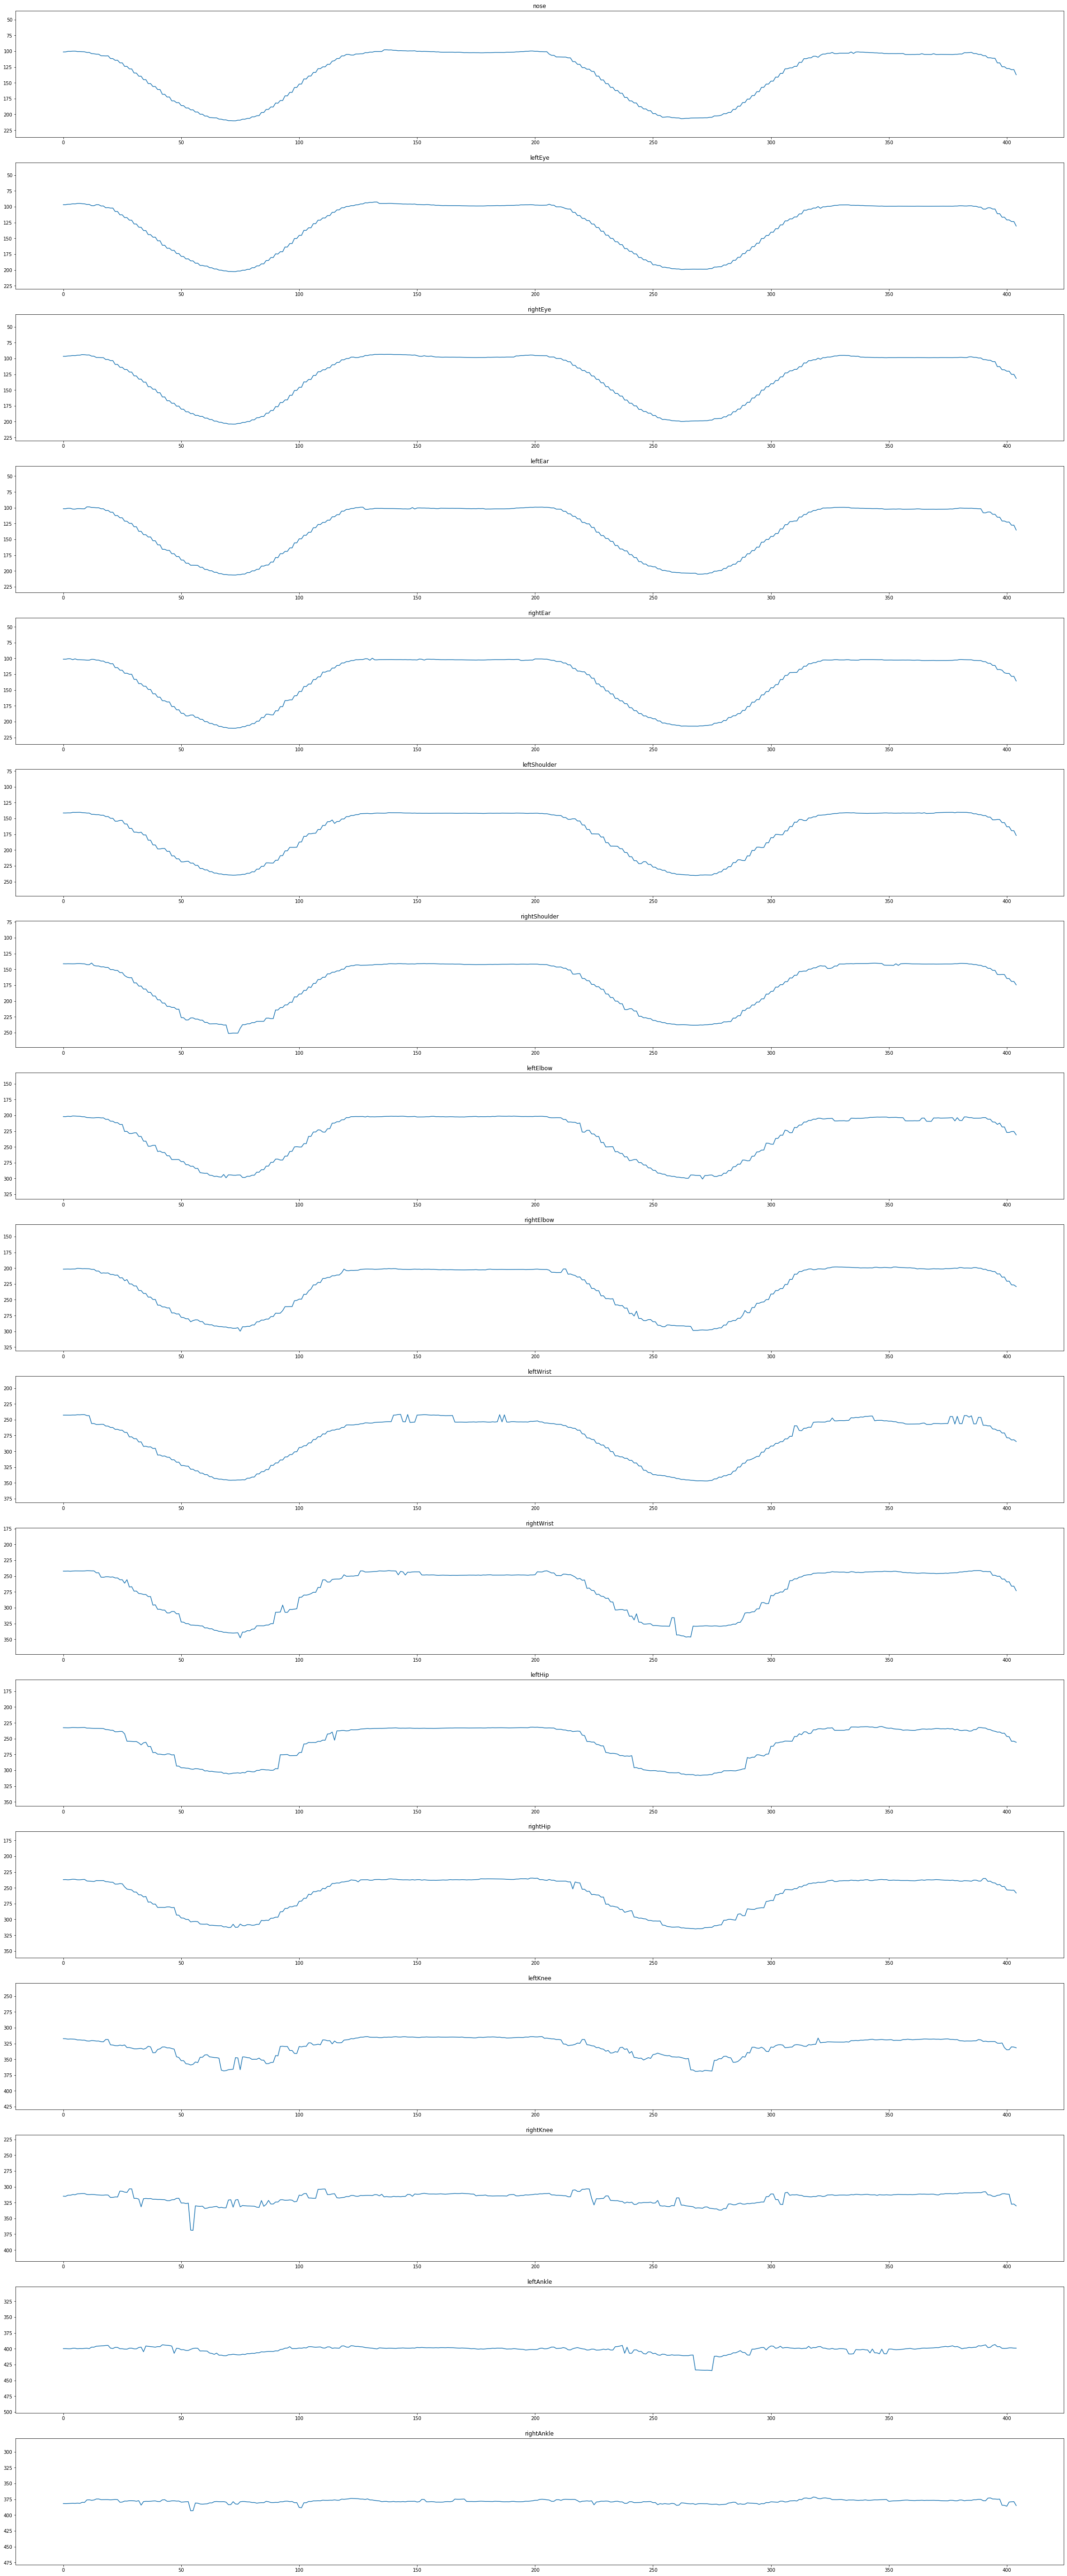

In [11]:
fig, part_axis = plt.subplots(17, 1, figsize=(40,100))
# Enumerate through each body part and graph it's frequency overtime
for index, axis in enumerate(part_axis):
    part_name = parts_dict[str(index)]
    
    # Retrieve datapoints
    y_points = workout_arr[:, index, 1]
    mean = np.mean(y_points)
    x_points = [i for i in range(0, len(y_points))]
    
    axis.plot(x_points, y_points)
    axis.set_title(part_name)
    axis.set_ylim(mean + 100, mean - 100)

## Graph the rate of increase or decrease along the y-axis for each exercise

In [12]:
def rate_of_change(body_part):
    # Calculate growth rates over time
    rate_of_increase = []
    # Calculate decay rates over time
    rate_of_decrease = []

    for i in range(10, len(body_part)):
        past = body_part[i-10]
        present = body_part[i]

        # Calculate growth rates
        growth_rate = (present - past) / past
        rate_of_increase.append(growth_rate * 100)

        # Calculate decay rates
        decay_rate = (past - present) / present
        rate_of_decrease.append(decay_rate * 100)
    
    return rate_of_increase, rate_of_decrease

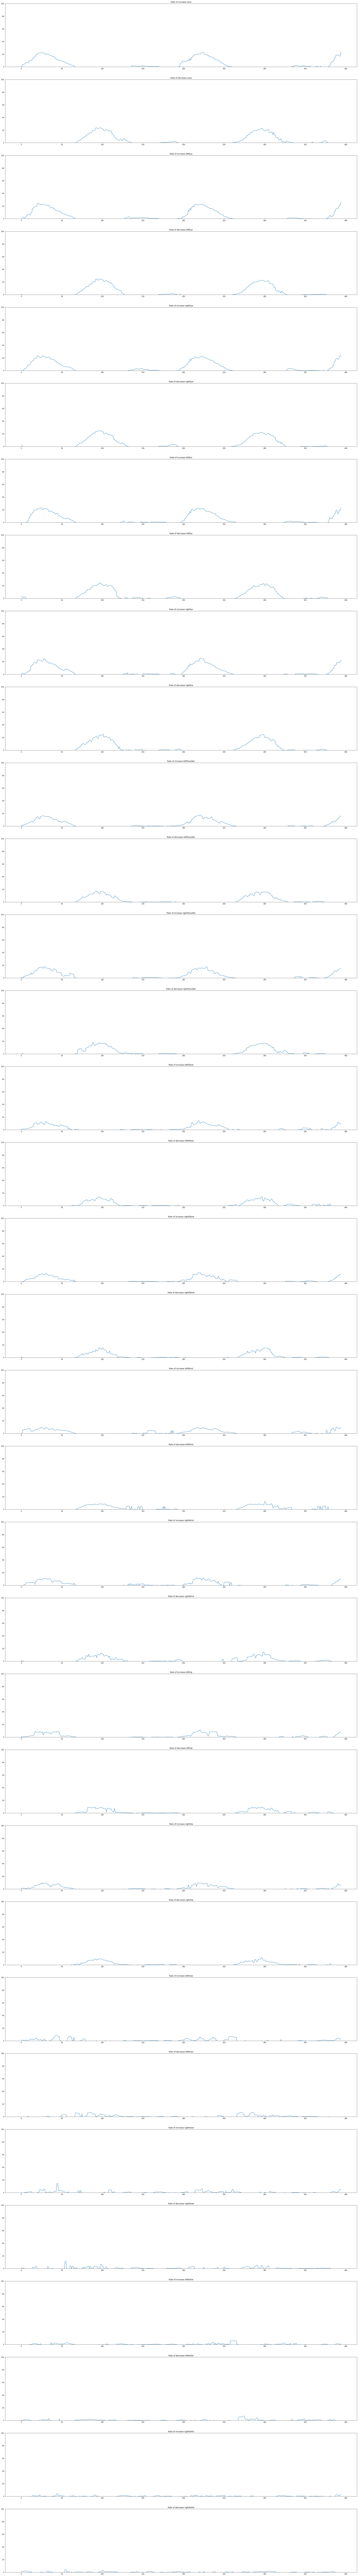

In [13]:
fig, part_axis = plt.subplots(17*2, 1, figsize=(40,300))
# Enumerate through each body part and graph it's frequency overtime
inc_index = 0
dec_index = 1
for index in range(0, 17):
    part_name = parts_dict[str(index)]
    
    # Retrieve datapoints
    body_part_arr = workout_arr[:, index, 1]

    rate_of_increase, rate_of_decrease = rate_of_change(body_part_arr)
    
    x_points = [i for i in range(0, len(rate_of_increase))]
    
    # inc graph
    part_axis[inc_index].plot(x_points, rate_of_increase)
    part_axis[inc_index].set_title("Rate of increase {}".format(part_name))
    part_axis[inc_index].set_ylim(0, 100)
    
    # dec graph
    part_axis[dec_index].plot(x_points, rate_of_decrease)
    part_axis[dec_index].set_title("Rate of decrease {}".format(part_name))
    part_axis[dec_index].set_ylim(0, 100)
    
    inc_index += 2
    dec_index += 2

## Graph the area of a user over time

In [14]:
full_user = workout_arr[51, :, :]

# Get height of user at timestamp
def get_height_and_width(user):
    # Grab all x-coordinates of the user
    x_axis = user[:, 0]
    # Grab all y-coordinates of the user
    y_axis = user[:, 1]
    
    # obtain max and mins for each axis
    x_min = x_axis.min()
    x_max = x_axis.max()
    y_min = y_axis.min()
    y_max = y_axis.max()
    # calculate the height and width
    height = int(abs(y_max - y_min))
    width = int(abs(x_max - x_min))
    
    return width, height
    
get_height_and_width(full_user)

(105, 222)

In [15]:
workout_arr = workout_data["keypoints"].to_numpy()
workout_arr = np.stack(workout_arr, axis=0)

In [16]:
workout_arr.shape

(405, 17, 2)

Text(0.5, 1.0, 'Area over time')

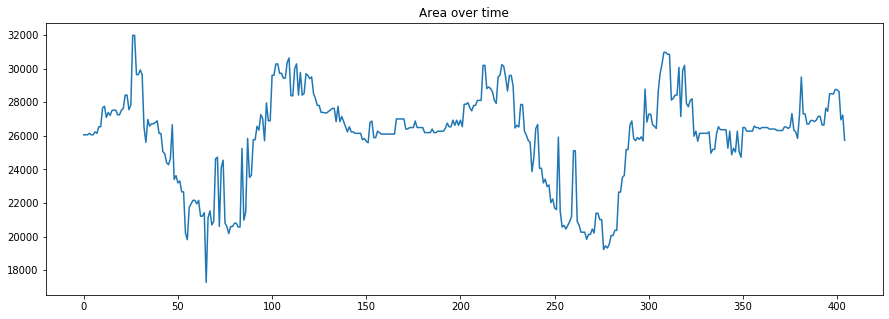

In [17]:
fig, axis = plt.subplots(1, 1, figsize=(15,5))

# Calculate area over time
area_over_time = []
for timestamp in workout_arr:
    # Calculate the area at a given time stamp
    width, height = get_height_and_width(timestamp)
    area_over_time.append(width * height)

# Plot area over time
x_points = [i for i in range(0, len(area_over_time))]
axis.plot(x_points, area_over_time)
axis.set_title("Area over time")

## Calculate the rate of increase over time

In [18]:
# Calculate growth rates over time
growth_rates = []
# Calculate decay rates over time
decay_rates = []

for i in range(10, len(area_over_time)):
    past = area_over_time[i-10]
    present = area_over_time[i]
    
    # Calculate growth rates
    growth_rate = (present - past) / past
    growth_rates.append(growth_rate * 100)
    
    # Calculate decay rates
    decay_rate = (past - present) / present
    decay_rates.append(decay_rate * 100)

Text(0.5, 1.0, 'Growth rates over time')

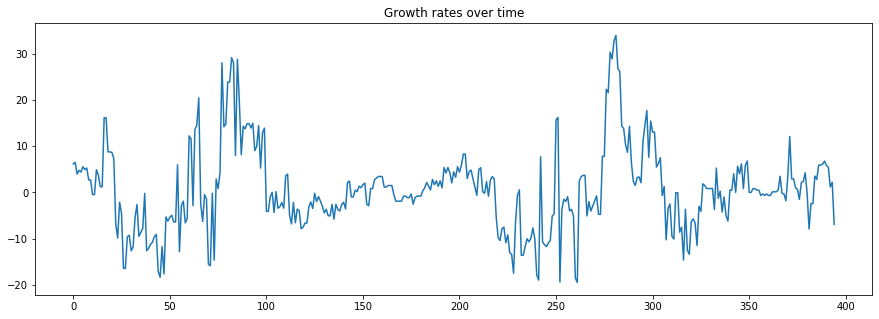

In [19]:
fig, axis = plt.subplots(1, 1, figsize=(15,5))

# Plot area over time
x_points = [i for i in range(0, len(growth_rates))]
axis.plot(x_points, growth_rates)
axis.set_title("Growth rates over time")

## Compare area of growth graph with the growth rate graph

(0, 100)

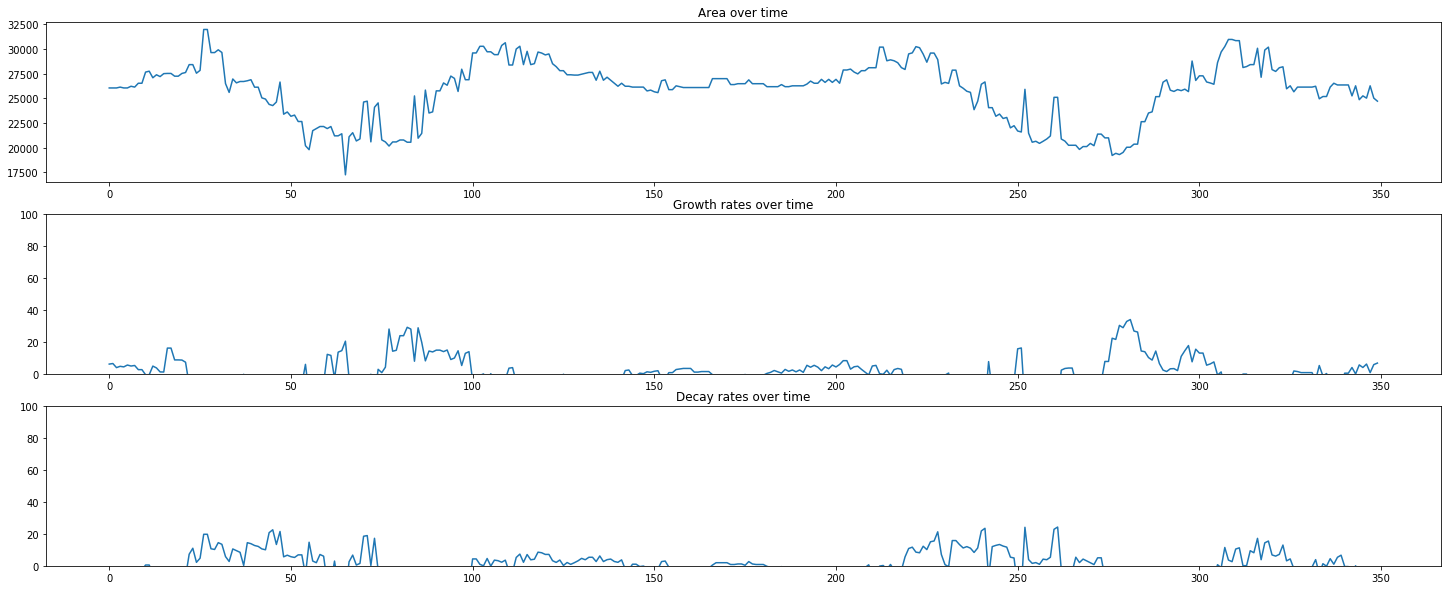

In [20]:
fig, (area_axis, growth_axis, decay_axis) = plt.subplots(3, 1, figsize=(25,10))
# Plot area over time
x_points = [i for i in range(0, len(growth_rates))]

area_axis.plot(x_points[:350], area_over_time[:350])
area_axis.set_title("Area over time")
growth_axis.plot(x_points[:350], growth_rates[:350])
growth_axis.set_title("Growth rates over time")
growth_axis.set_ylim(0, 100)
decay_axis.plot(x_points[:350], decay_rates[:350])
decay_axis.set_title("Decay rates over time")
decay_axis.set_ylim(0, 100)